In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage import io
import cv2
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import time
import os
import PIL.Image as Image
from IPython.display import display, clear_output

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

# Reproducibility
torch.manual_seed(777)
torch.cuda.manual_seed(777)
np.random.seed(777)
random.seed(777)
torch.backends.cudnn.deterministic=True

cpu


Подготовим датасет MNIST

In [2]:
from torchvision.datasets import MNIST

transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Исследуем визуально изменение распределение признаков для разных лоссов. Итоговый лосс будет иметь вид<br>
$$L=L_{0} + \lambda L_{1}$$<br>
В качетве $L_0$ возьмем обычную кросс-энтропию, а $L_1$ будет меняться в ходе исследования.

Начнем с реализации следующих лоссов:

In [6]:
from IPython.display import Image

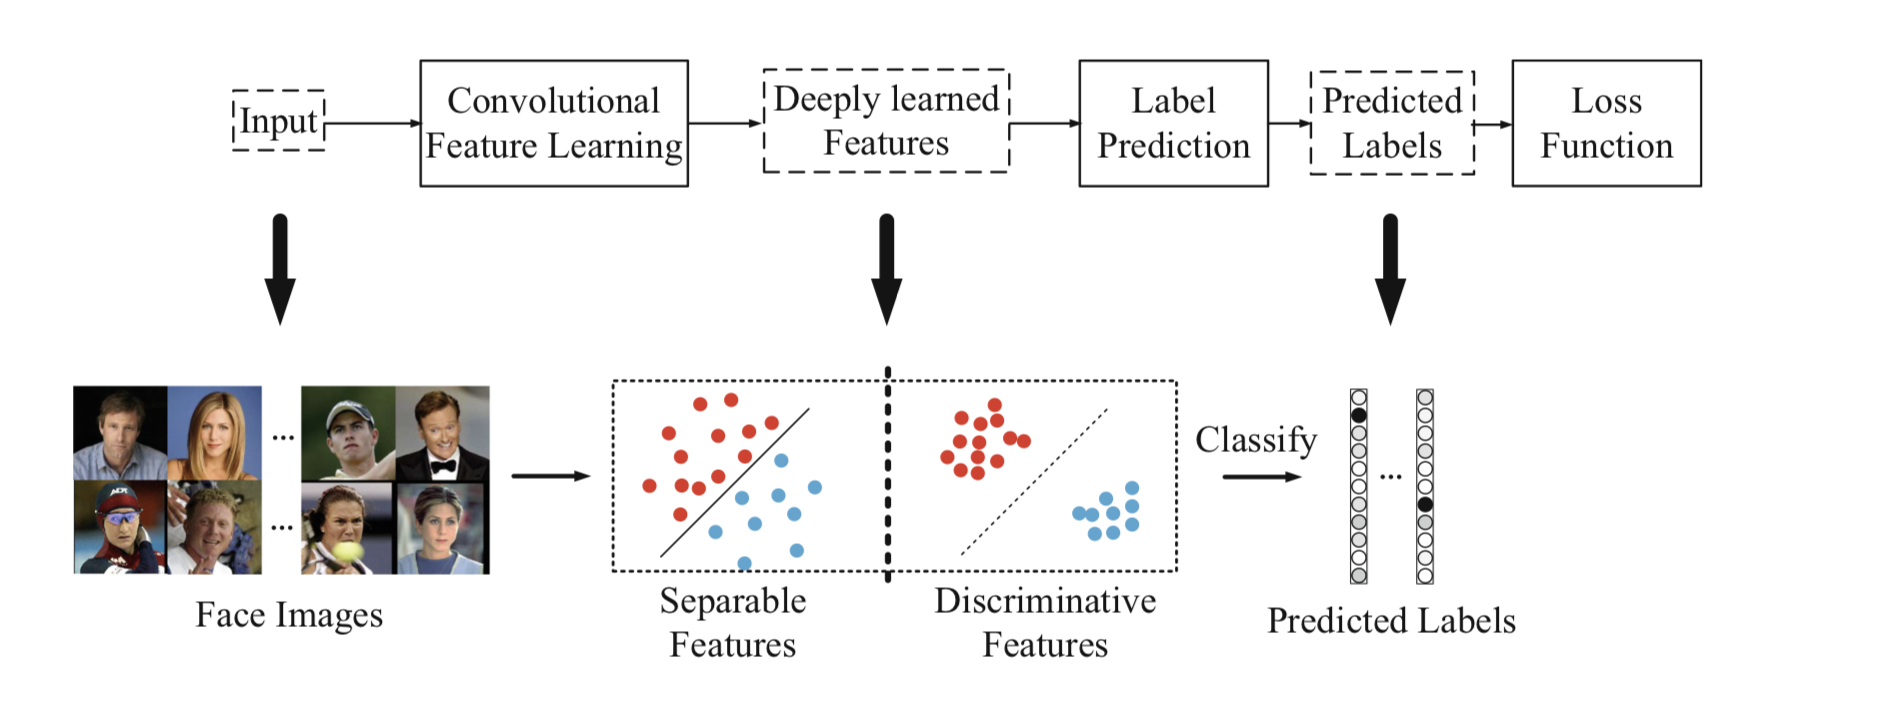

In [12]:
Image('/Users/n.balabin/Desktop/1.png')

- Center Loss https://ydwen.github.io/papers/WenECCV16.pdf:<br>
$$L_1=\frac{1}{2N}\sum_{i=1}^N\|\mathcal{F}(x_i) - c_{y_i}\|_2^2$$

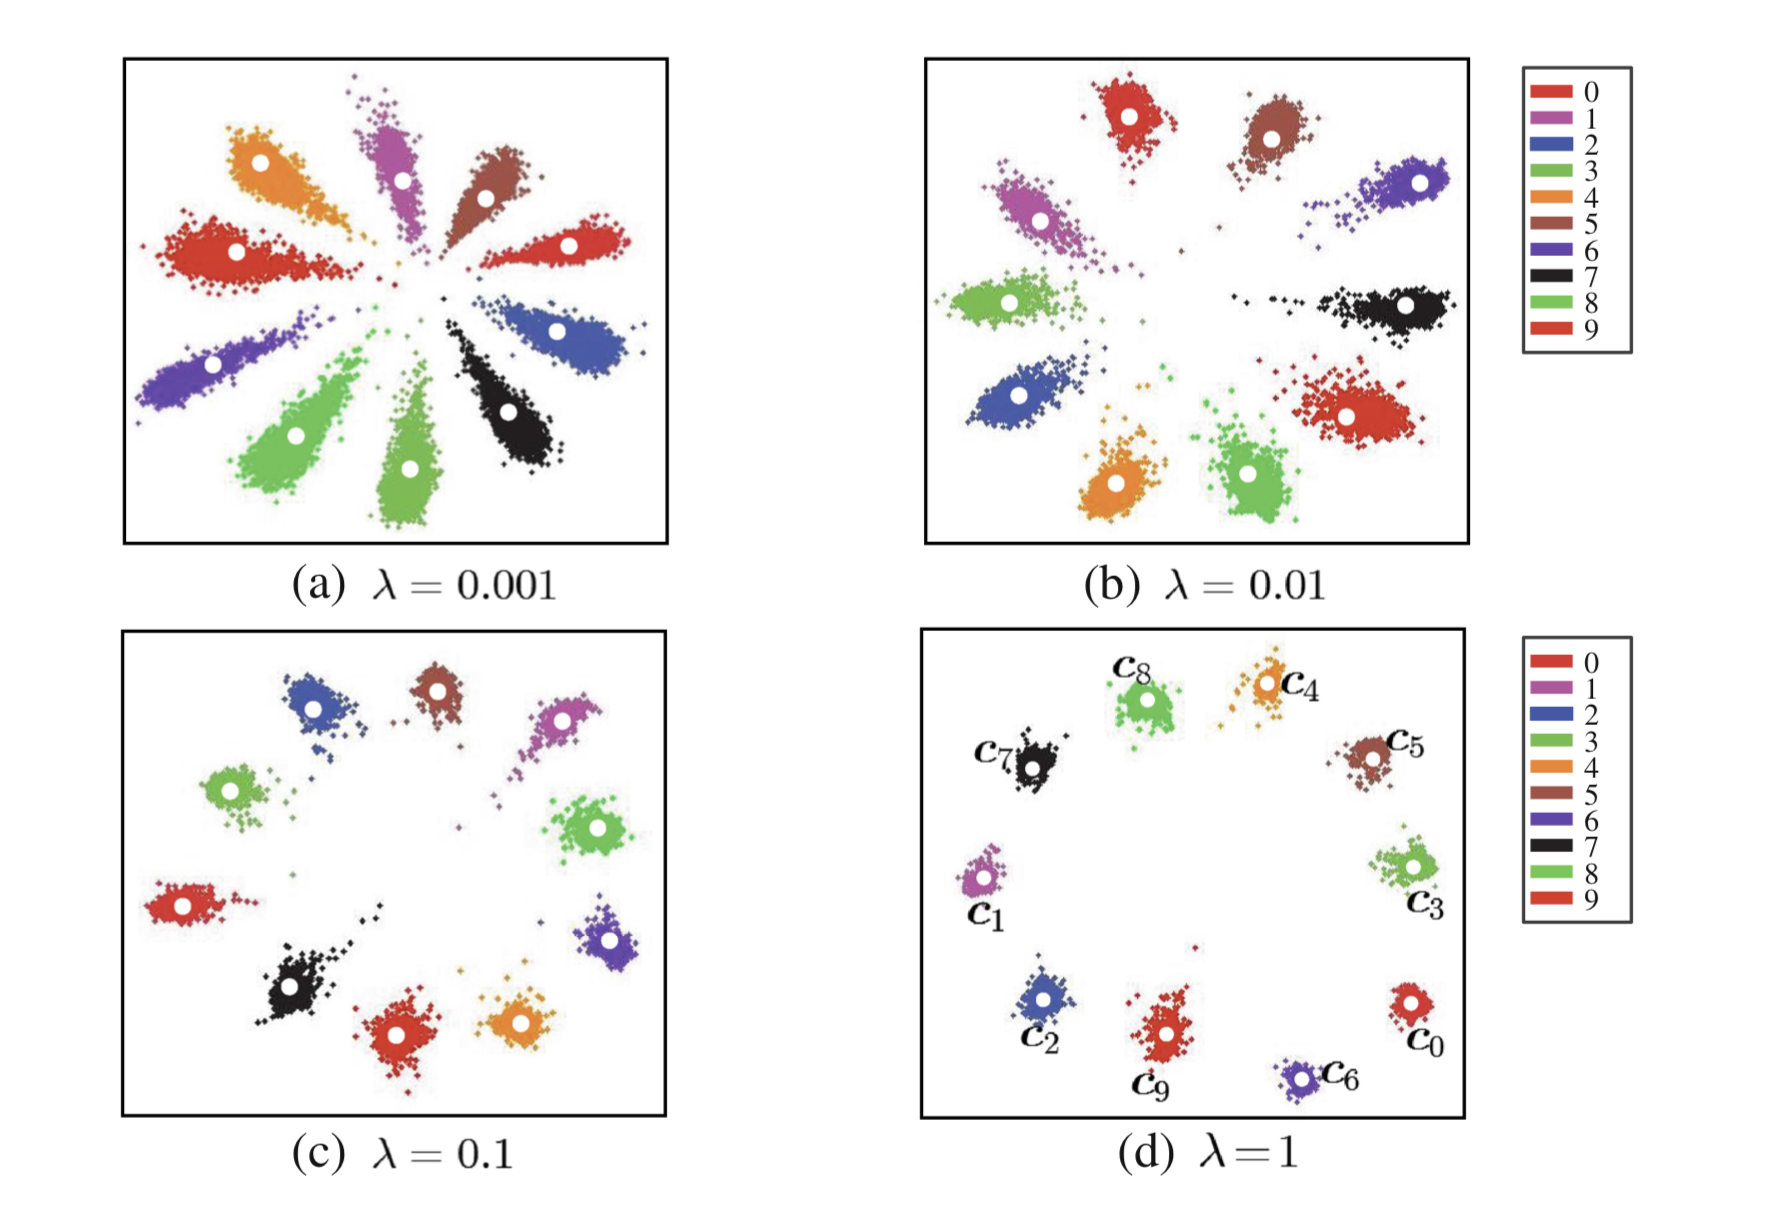

In [13]:
Image('/Users/n.balabin/Desktop/2.png')

- Contrasitive Center Loss https://arxiv.org/abs/1707.07391 (исправленный мной):<br>
$$L_1=\frac{K-1}{N}\cdot\sum_{i=1}^N{\frac{\|\mathcal{F}(x_i) - c_{y_i}\|_2^2}{\sum_{k=1,\;k\neq y_i}^K\|\mathcal{F}(x_i) - c_{k}\|_2^2}}$$

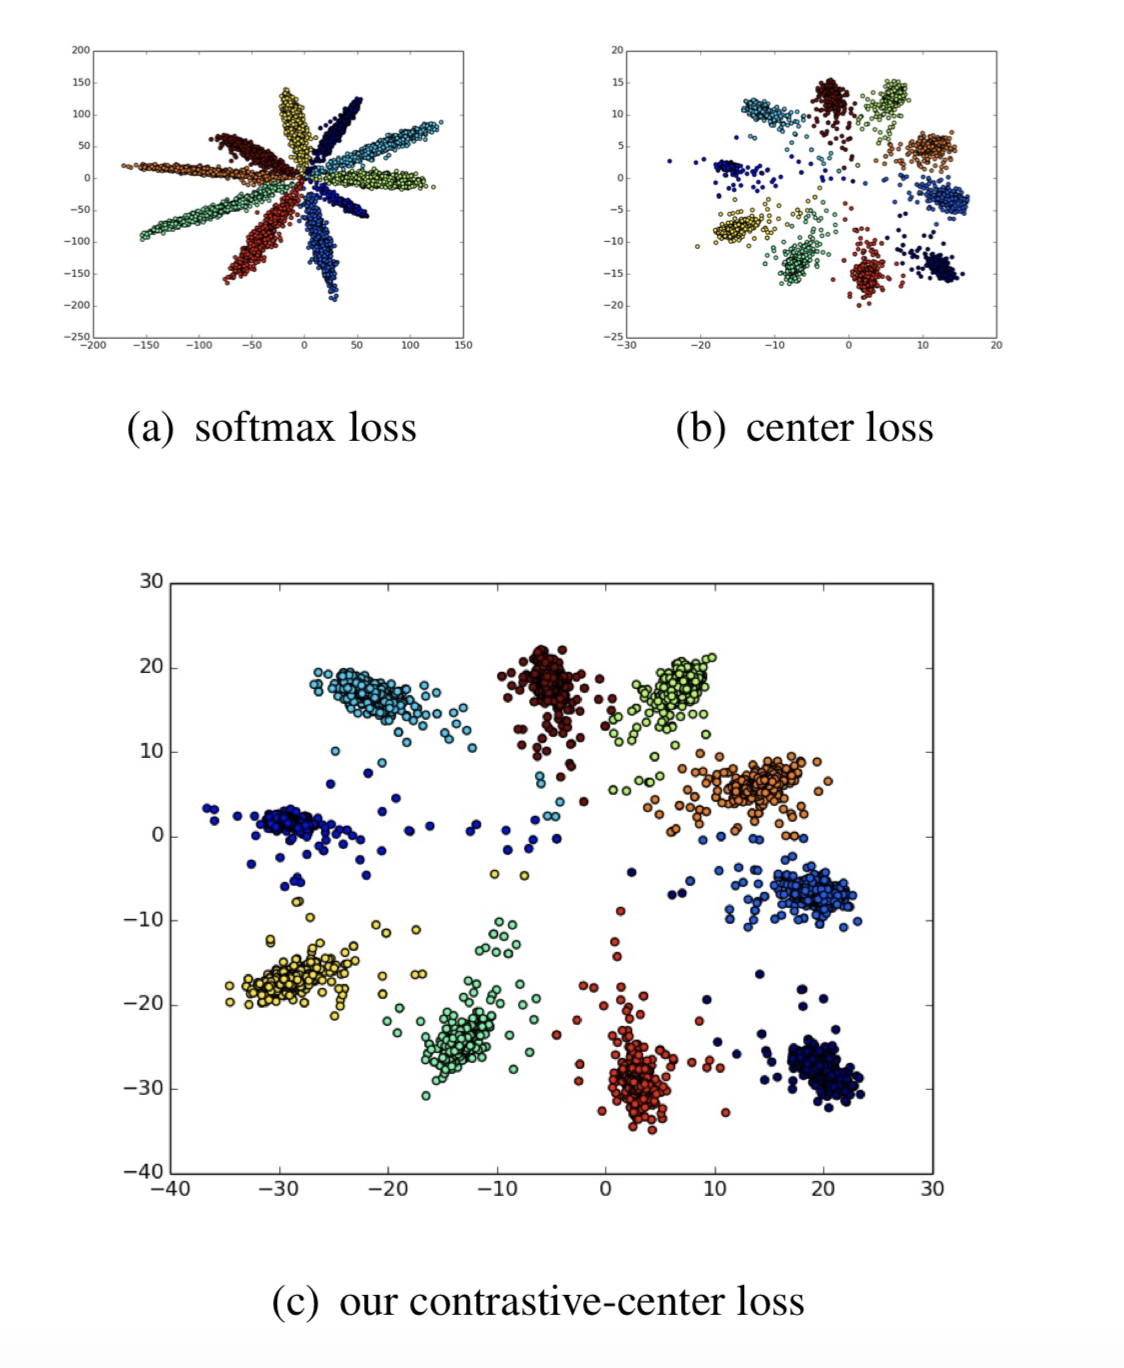

In [15]:
Image('/Users/n.balabin/Desktop/3.png')

In [3]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes=10, feat_dim=2, type='center'):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).to(device))
        self.type = type

    def forward(self, features, labels):
        batch_size = features.size(0)
        distmat = torch.pow(features, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, features, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        classes = classes.to(device)
        
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        intra_dist = distmat * mask.float()
        inter_dist = distmat * (1.0 - mask.float())
        if self.type == 'center':
            loss = intra_dist.clamp(min=1e-12, max=1e+12).sum() * 0.5 / batch_size
        elif self.type == 'contra-center':
            loss = (intra_dist.clamp(min=1e-12, max=1e+12).sum(1) / inter_dist.clamp(min=1e-12, max=1e+12).sum(1)).sum() \
            / batch_size * (self.num_classes - 1)

        return loss

Реализация<br>
- Ring Loss https://arxiv.org/abs/1803.00130
$$L_1=\frac{1}{2N}\sum_{i=1}^N(\|\mathcal{F}(x_i)\|_2 - R)^2$$

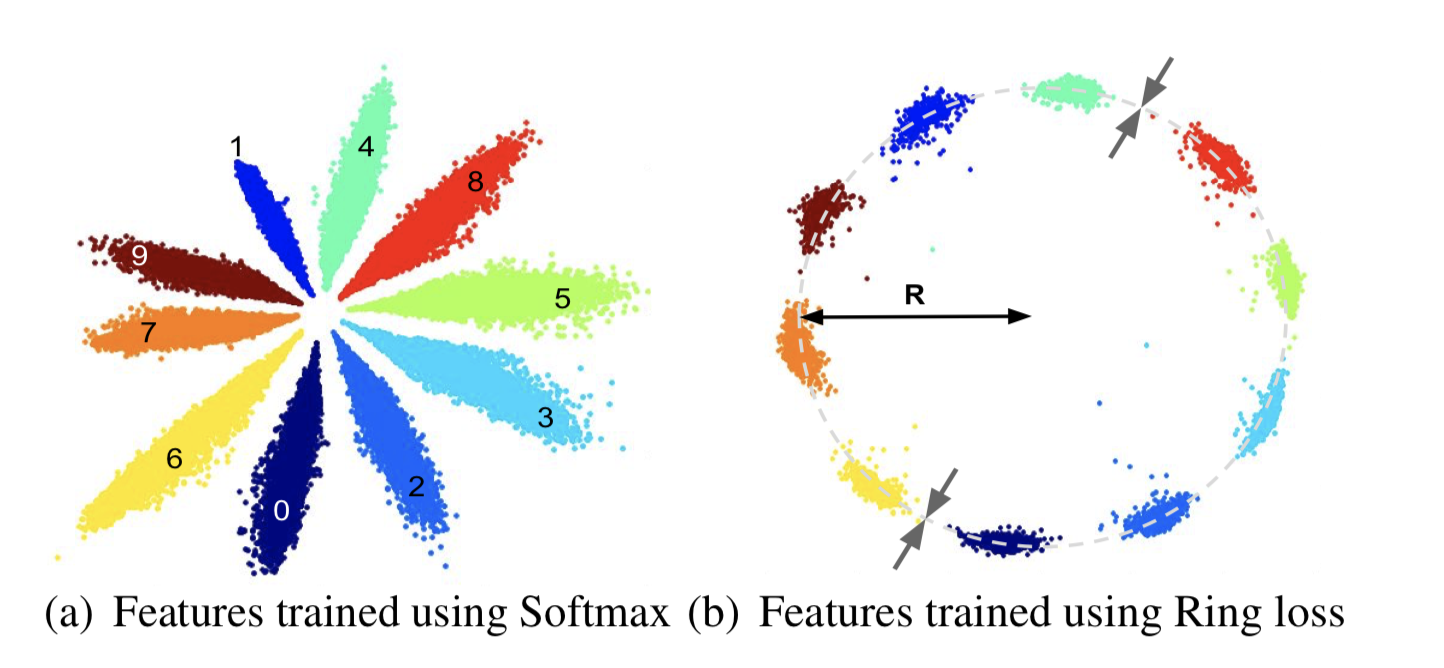

In [16]:
Image('/Users/n.balabin/Desktop/4.png')

In [4]:
class RingLoss(nn.Module):
    def __init__(self, type='L2'):
        super(RingLoss, self).__init__()
        self.radius = nn.Parameter(torch.Tensor(1))
        self.radius.data.fill_(-1)
        self.type = type

    def forward(self, features):
        x = features.pow(2).sum(dim=1).pow(0.5).view(-1, 1)
        if self.radius.data[0] < 0: # Initialize the radius with the mean feature norm of first iteration
            self.radius.data.fill_(x.mean().item())
        if self.type == 'auto': # Divide the L2 Loss by the feature's own norm
            diff = x.sub(self.radius.expand_as(x).to(device)) / (x.mean().detach().clamp(min=0.5))
            diff_sq = torch.pow(torch.abs(diff), 2).mean()
            ringloss = diff_sq.mul_(1.0)
        else: # default: L2 Loss
            diff = x.sub(self.radius.expand_as(x).to(device))
            diff_sq = torch.pow(torch.abs(diff), 2).mean()
            ringloss = diff_sq.mul_(1.0)
        return ringloss

Реализация<br>
- LGM Loss https://arxiv.org/pdf/1803.02988<br>
$$p\left(x_{i} | y_{i}\right)=\mathcal{N}\left(x_{i} ; \mu_{y_{i}}, \Sigma_{y_{i}}\right)$$<br>
$$p\left(y_{i} | x_{i}\right)=\frac{\mathcal{N}\left(x_{i} ; \mu_{y_{i}}, \Sigma_{y_{i}}\right) p\left(y_{i}\right)}{\sum_{k=1}^{K} \mathcal{N}\left(x_{i} ; \mu_{k}, \Sigma_{k}\right) p(k)}$$<br>
$$ L_{0} =-\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} \mathbb{1}\left(y_{i}=k\right) \log p\left(k | x_{i}\right) = -\frac{1}{N} \sum_{i=1}^{N} \log \frac{\mathcal{N}\left(x_{i} ; \mu_{y_{i}}, \Sigma_{y_{i}}\right) p\left(y_{i}\right)}{\sum_{k=1}^{K} \mathcal{N}\left(x_{i} ; \mu_{k}, \Sigma_{k}\right) p(k)}$$<br>
$$L_{1}=-\sum_{i=1}^{N} \log \mathcal{N}\left(x_{i} ; \mu_{y_{i}}, \Sigma_{y_{i}}\right)$$
Для большей разделимости в <br>
$$L_{0,i}=-\log \frac{p\left(z_{i}\right)\left|\Sigma_{y_{i}}\right|^{-\frac{1}{2}} e^{-d_{y_{i}}}}{\sum_{k} p(k)\left|\Sigma_{k}\right|^{-\frac{1}{2}} e^{-d_{k}}},\;\;\;d_{k}=\frac{1}{2}\left(x_{i}-\mu_{k}\right)^{T} \Sigma_{k}^{-1}\left(x_{i}-\mu_{k}\right)$$<br>
вводится дополнительная разделительная граница (margin) $\alpha$:
$$L_{0,i}=-\log \frac{p\left(z_{i}\right)\left|\Sigma_{y_{i}}\right|^{-\frac{1}{2}} e^{-d_{y_{i}}(1+\alpha)}}{\sum_{k} p(k)\left|\Sigma_{k}\right|^{-\frac{1}{2}} e^{-d_{k}(1+\mathbb{1}(k=y_i)\alpha)}}$$.<br>
Кроме того, предпологается, что ковариционная матрица $\Sigma_k$ диагональна -- $\Lambda_k$, a вероятности $p(k)=1/K$.<br>
Тогда итоговый лосс $L_0+\lambda L_1$ берется следующий:
$${L}_{G M, i}^{\alpha}=-\log \frac{\left|\Lambda_{y_{i}}\right|^{-\frac{1}{2}} e^{-d_{y_{i}}(1+\alpha)}}{\sum_{k}\left|\Lambda_{k}\right|^{-\frac{1}{2}} e^{-d_{k}\left(1+1\left(k=y_{i}\right) \alpha\right)}}
+\lambda\left(d_{y_{i}}+\frac{1}{2} \log \left|\Lambda_{y_{i}}\right|\right),\;\;\;d_{k}=\frac{1}{2}\left(x_{i}-\mu_{k}\right)^{T} \Lambda_{k}^{-1}\left(x_{i}-\mu_{k}\right)
$$

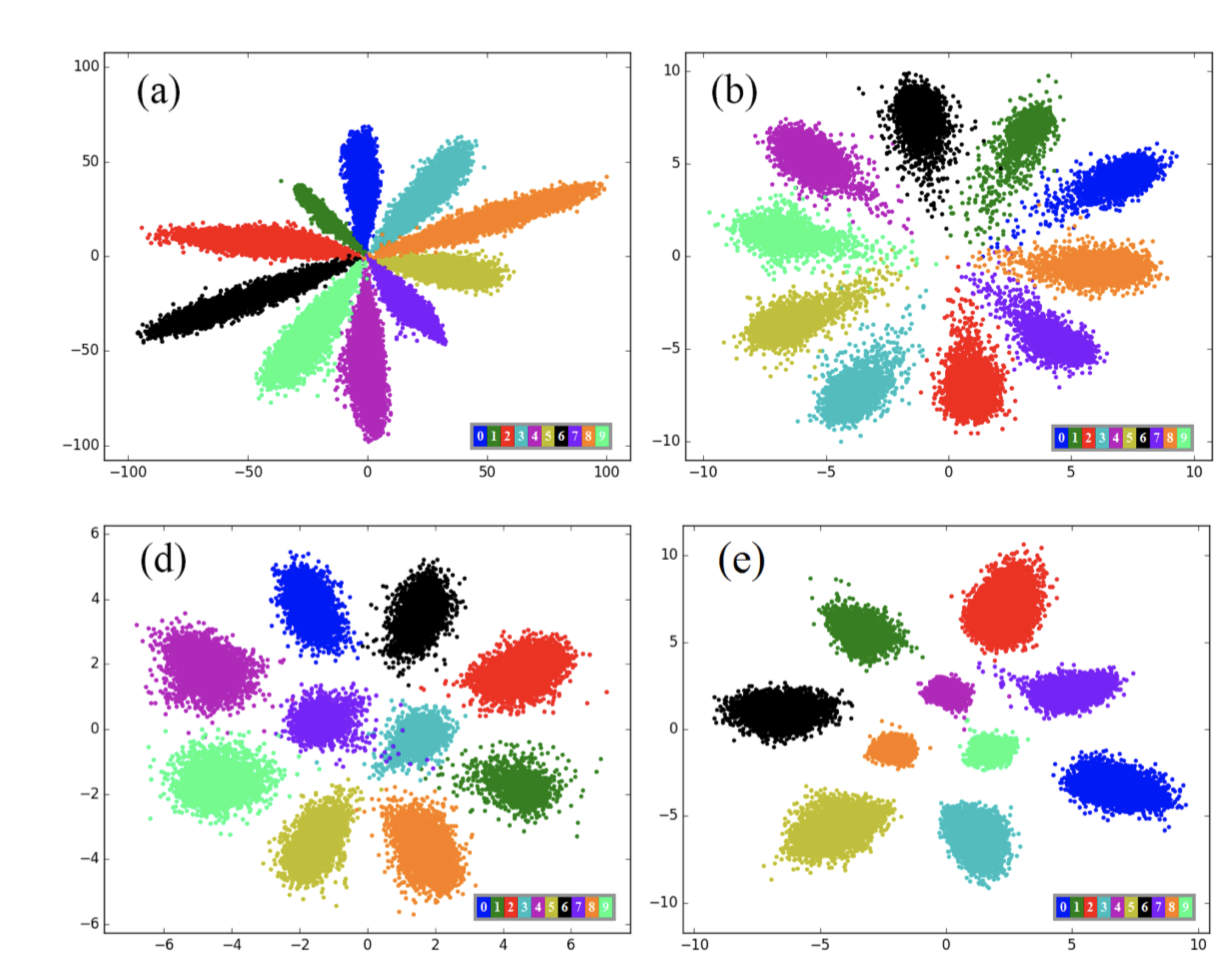

In [17]:
Image('/Users/n.balabin/Desktop/5.png')

In [5]:
class LGMLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, alpha):
        super(LGMLoss, self).__init__()
        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.alpha = alpha

        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.log_covs = nn.Parameter(torch.ones(num_classes, feat_dim)) # * -4.0

    def forward(self, features, labels):
        batch_size = features.shape[0]
        log_covs = torch.unsqueeze(self.log_covs, dim=0)

        covs = torch.exp(log_covs) 
        tcovs = covs.repeat(batch_size, 1, 1)
        diff = torch.unsqueeze(features, dim=1) - torch.unsqueeze(self.centers, dim=0)
        wdiff = torch.div(diff, tcovs)
        diff = torch.mul(diff, wdiff)
        dist = torch.sum(diff, dim=-1) 

        y_onehot = torch.FloatTensor(batch_size, self.num_classes)
        y_onehot.zero_()
        y_onehot = Variable(y_onehot).to(device)
        y_onehot.scatter_(1, torch.unsqueeze(labels, dim=-1), self.alpha)
        y_onehot = y_onehot + 1.0
        margin_dist = torch.mul(dist, y_onehot)

        slog_covs = torch.sum(log_covs, dim=-1)
        tslog_covs = slog_covs.repeat(batch_size, 1)
        margin_logits = -0.5 * (tslog_covs + margin_dist)
        logits = -0.5 * (tslog_covs + dist)

        cdiff = features - torch.index_select(self.centers, dim=0, index=labels.long())
        cdist = cdiff.pow(2).clamp(min=1e-12, max=1e+12).sum(1).sum(0) / 2.0

        slog_covs = torch.squeeze(slog_covs)
        reg = 0.5 * torch.sum(torch.index_select(slog_covs, dim=0, index=labels.long()))
        likelihood = (1.0 / batch_size) * (cdist + reg)

        return logits, margin_logits, likelihood

Функция обучения

In [6]:
def train(model, epochs, optimizer, loss, scheduler, add_optimizer, add_loss, add_scheduler, add_weight=0.1, name="empty"):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            model.train()
            losses = 0.
            accuracies = 0.
            size = 0.
            for k, (X, y) in enumerate(train_loader):
                X = X.to(device)
                y = y.to(device)
                model.zero_grad()
                features, prediction = model(X)
                
                if name == 'ring':
                    loss_batch = loss(prediction, y)
                    add_loss_batch = add_loss(features)
                elif name=='lgm':
                    prediction, mlogits, likelihood = add_loss(features, y)
                    loss_batch = loss(mlogits, y)
                    add_loss_batch = likelihood
                elif 'center' in name:
                    loss_batch = loss(prediction, y)
                    add_loss_batch = add_loss(features, y)
                elif name=='simple':
                    loss_batch = loss(prediction, y)
                    add_loss_batch = add_loss(features, y)
                    add_weight = 1e-16
                add_loss_batch *= add_weight
                print(f'\r{loss_batch.item():.10f}\t{add_loss_batch.item():.10f}', end='')
                loss_batch += add_loss_batch
                
                optimizer.zero_grad()
                add_optimizer.zero_grad()
                
                loss_batch.backward()
                optimizer.step()
                for param in add_loss.parameters():
                    param.grad.data *= (1. / add_weight)
                add_optimizer.step()
                
                _, predicted = torch.max(prediction.data, 1)
                losses += loss_batch.item()
                
                size += y.size(0)
                accuracies += (predicted==y).sum().item()
            
                plt.scatter(features[:,0].cpu().detach().numpy(),
                            features[:,1].cpu().detach().numpy(),
                            c=y.cpu().detach().numpy(), s=2, cmap='gist_rainbow')

            plt.savefig(f'images/{name}.{epoch}.train.png', dpi=224)
            plt.close()
            
            
            train_loss_epochs.append(losses / len(train_loader))
            train_accuracy_epochs.append(accuracies / size)
            
            model.eval()
            losses = 0.
            accuracies = 0.  
            size = 0.
            with torch.no_grad():
                for X, y in test_loader:
                    X = X.to(device)
                    y = y.to(device)
                    features, prediction = model(X)
                    
                    if name == 'ring':
                        loss_batch = loss(prediction, y)
                        add_loss_batch = add_loss(features)
                    elif name=='lgm':
                        prediction, mlogits, likelihood = add_loss(features, y)
                        loss_batch = loss(mlogits, y)
                        add_loss_batch = likelihood
                    elif 'center' in name:
                        loss_batch = loss(prediction, y)
                        add_loss_batch = add_loss(features, y)
                    elif name=='simple':
                        loss_batch = loss(prediction, y)
                        add_loss_batch = add_loss(features, y)
                        add_weight = 1e-16
                        
                    add_loss_batch *= add_weight
                    loss_batch += add_loss_batch
                    
                    _, predicted = torch.max(prediction.data, 1)
                    losses += loss_batch.item()
                    size += y.size(0)
                    accuracies += (predicted==y).sum().item()

                    plt.scatter(features[:,0].cpu().detach().numpy(),
                                features[:,1].cpu().detach().numpy(),
                                c=y.cpu().detach().numpy(), s=2, cmap='gist_rainbow')
                
                plt.savefig(f'images/{name}.{epoch}.test.png', dpi=224)
                plt.close()
                
                test_loss_epochs.append(losses / len(test_loader))
                test_accuracy_epochs.append(accuracies / size)
            
            scheduler.step()
            if name == 'lgm':
                add_scheduler.step()
            
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            #plt.yscale('log')
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('both')
            plt.show()
            
    except KeyboardInterrupt:
        pass
    
    return model, train_accuracy_epochs, test_accuracy_epochs

Реализация LeNet++

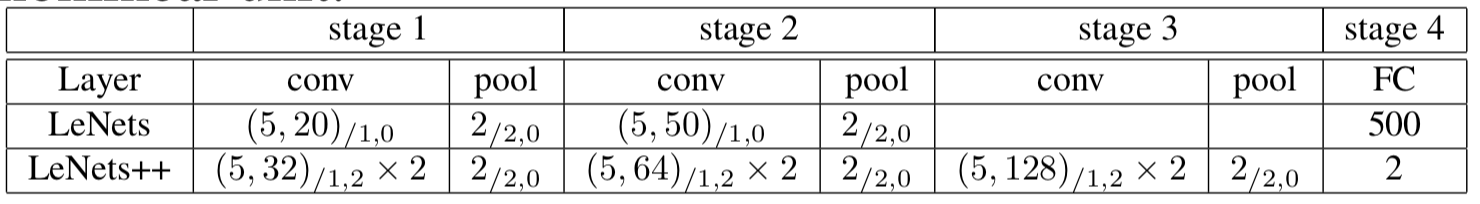

In [18]:
Image('/Users/n.balabin/Desktop/6.png')

In [14]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 32, 5, stride=1, padding=2), nn.PReLU(),
                                         nn.Conv2d(32, 32, 5, stride=1, padding=2), nn.PReLU(),
                                         nn.MaxPool2d(2), 
                                         nn.Conv2d(32, 64, 5, stride=1, padding=2), nn.PReLU(),
                                         nn.Conv2d(64, 64, 5, stride=1, padding=2), nn.PReLU(),
                                         nn.MaxPool2d(2), 
                                         nn.Conv2d(64, 128, 5, stride=1, padding=2), nn.PReLU(),
                                         nn.Conv2d(128, 128, 5, stride=1, padding=2), nn.PReLU(),
                                         nn.MaxPool2d(2))
        self.features2d = nn.Sequential(nn.Linear(128*3*3, 2), nn.PReLU())
        self.linear_layers = nn.Linear(2, 10)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        features = self.features2d(x)
        x = self.linear_layers(features)
        return features, x

In [15]:
#del model
model = ConvClassifier().to(device)

Обучаем модели

In [16]:
names = ['simple', 'center', 'contra-center', 'ring', 'lgm']
full_names = ['Cross Entropy', 'Center Loss', 'Contrasitive Center Loss', 'Ring Loss', 'LGM Loss']
        
add_weights = [0.0, 0.5, 2.0, 2.0, 0.1]

In [ ]:
%%time
EPOCHS = 100
train_accs = {}
test_accs = {}
train_acc = {}
test_acc = {}

for name, add_weight in zip(names[-1:], add_weights[-1:]):
    
    print(name, add_weight)
    
    del model
    # Reproducibility
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic=True
    
    model = ConvClassifier().to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)

    
    if name in ['simple', 'center']:
        add_loss = CenterLoss(num_classes=10, feat_dim=2, type='center')
    elif name == 'contra-center':
        add_loss = CenterLoss(num_classes=10, feat_dim=2, type='contra-center')
    elif name == 'ring':
        add_loss = RingLoss(type='auto')
    elif name == 'lgm':
        add_loss = LGMLoss(num_classes=10, feat_dim=2, alpha=0.1).to(device)
        
    if name != 'lgm':
        add_optimizer = torch.optim.SGD(add_loss.parameters(), lr=0.5, momentum=0.9)
    else:
        add_optimizer = torch.optim.SGD(add_loss.parameters(), lr=0.01, momentum=0.9)
    
    if name != 'lgm':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
        add_scheduler = None
    else:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
        add_scheduler = optim.lr_scheduler.StepLR(add_optimizer, step_size=10, gamma=0.5)
        
    model, train_accs[name], test_accs[name] = train(model, EPOCHS, optimizer, loss, scheduler,
                                                     add_optimizer, add_loss, add_scheduler,
                                                     add_weight=add_weight, name=name)
    train_acc[name] = train_accs[name][-1]
    test_acc[name] = test_accs[name][-1]
    
    clear_output(False)

Визуализируем распределение признаков

In [2]:
from skimage import io
from ipywidgets import interact, interact_manual, FloatSlider

EPOCHS = 75
names = ['simple', 'center', 'contra-center', 'ring', 'lgm']
full_names = ['Cross Entropy', 'Center Loss', 'Contrasitive Center Loss', 'Ring Loss', 'LGM Loss']
name_dct = {v: u for u,v in zip(names, full_names)}

images_train = {}
images_test = {}
for name in names:
    images_train[name] = [io.imread(f'images/{name}.{x}.train.png') for x in range(0, EPOCHS)]
    images_test[name] = [io.imread(f'images/{name}.{x}.test.png') for x in range(0, EPOCHS)]

@interact(full_name=full_names, epoch=(0, EPOCHS-1))
def func(full_name='Cross Entropy', epoch=0):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(images_train[name_dct[full_name]][epoch])
    plt.title('TRAIN')
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(images_test[name_dct[full_name]][epoch])
    plt.title('TEST')
    plt.show()

interactive(children=(Dropdown(description='full_name', options=('Cross Entropy', 'Center Loss', 'Contrasitive…

## EOF